In [37]:
using ForwardDiff    # For computing gradients using automatic differentiation
using LinearAlgebra 
using Plots # For plots
pyplot() # For plots
#test

## Functions to compute gradient, hessian and first derivative
∇(f,x) = ForwardDiff.gradient(f, x);
H(f,x)  = ForwardDiff.hessian(f, x);
D(θ,λ) = ForwardDiff.derivative(θ, λ)

## Select which line search method to use.
@enum LS ARMIJO GOLDEN

UndefVarError: UndefVarError: Pkg not defined

## Exact line search : golden section
### Parameters: 
 θ: line search function
 
 a: initial lower bound
 
 b: initial upper bound

In [2]:
function golden_ls(θ, a, b)
 
    l  = 1e-7                     # Tolerance (length of uncertainty)
    α  = 1/Base.MathConstants.φ   # φ = golden ratio. Here α ≈ 0.618
    
    λ  = a + (1-α)*(b - a)        # NOTE: We do not need to index a, b, λ, and μ like in the lecture 5 pseudocode
    μ  = a + α*(b - a)            #       Instead, we can keep reusing and updating the same variables for notational convenience

    θμ = θ(a + α*(b - a))         # Use this variable to compute function values Θ(μₖ₊₁) as in the pseudocode of Lecture 5
    θλ = θ(a + (1 - α)*(b - a))   # Use this variable to compute function values Θ(λₖ₊₁) as in the pseudocode of Lecture 5
    
    ## TODO: Implement what should be inside the while loop of Golden Section method
    while b - a > l
        if θλ > θμ
            a = λ
            λ = μ
            θλ = θμ
            μ = a + α*(b - a)
            θμ = θ(μ) 
        else
            b = μ
            μ = λ
            θμ = θλ
            λ  = a + (1-α)*(b - a)
            θλ = θ(λ)
        end      
    end
    
    return (a + b)/2              # Finally, the function returns the centre point of the final interval
    
end

golden_ls (generic function with 1 method)

## Inexact line search : Armijo rule
### Parameters: 

θ: line search function

λ: initial step size value (e.g. 1)

α: slope reduction factor

β: λ reduction factor

In [3]:
function Armijo_ls(θ, λ, α, β) 
    
    θ₀  = θ(0)                  # Function value at zero
    Dθ₀ = D(θ, 0)               # Derivative (slope) at zero   
    
    ## TODO: Implement what should be inside the while loop of Armijo method
    while θ(λ) > θ₀ + α*λ*Dθ₀   # Check termination condition
 
        ##tämä on minun
        λ = β*λ
        
    end
    
    return λ
    
end

Armijo_ls (generic function with 1 method)

## Gradient (descent) method
### Parameters
  f: function to minimize
  
  x: starting point
  
  N: maximum number of iterations
  
  LS: line search method (GOLDEN or ARMIJO)
  
  flag: the indicator of output (true - if you need the history of the iterations, false - if you need just cost and number of iterations)

  ### Keywork arguments
  
 ε: solution tolerance
 
 a: initial lower bound for Golden section method

 b: initial upper bound for Golden section method
 
 λ: initial step size value (e.g. 1) for Armijo's method
 
 α: slope reduction factor for Armijo's method
 
 β: λ reduction factor for Armijo's method
 

In [4]:
function Gradient(f, x, N, LS, flag; ε = tol, a = a₀, b = b₀, λ = λ₀, α = α₀, β = β₀)
    
    # if we need to save the history of iterations 
    (flag == true) && (x_iter = zeros(N, length(x))) # Equivalent to if flag == true then x_iter = zeros(N, length(x)) end
    
    for k = 1:N               # NOTE: initial x should be set to x0    
        
        ∇f     = ∇(f, x)      # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        ∇f    /= norm∇f       # Normalized gradient
        
        if norm∇f < ε         # Stopping condition #1
            
            if flag == true 
                
                return  (x_iter[1:k-1, :], k-1)    # Return  the history of cost, iterations            
            else
                
                return (f(x), k-1)                 # Return cost and iterations            
           
            end        
            
        end
        
        ## TODO: set the Gradient Descent direction
        d =   - (∇f / norm(∇f))                # Gradient method direction
        
        ########## START LINE SEARCH ###############
        θ(λ) = f(x + λ*d)
        LS == ARMIJO && (λ = Armijo_ls(θ, λ, α, β))         # Calls Armijo method to compute optimal step size λ 
        LS == GOLDEN && (λ = golden_ls(θ, a, b))            # Calls Golden Section method to compute optimal step size λ  
        ############ END LINE SEARCH ###############
       
        ## TODO: Update the solution x at this iteration accordingly
        x = x  + λ*d             # Update solution
        
        (flag == true) && (x_iter[k, :] = x) # save the history if needed
    end
    
    if flag == true
        return (x_iter, N)  # Return the history of cost, iterations
    else    
        return (f(x), N)   # Return cost, iterations  
    end
    
end

Gradient (generic function with 1 method)

## Heavy Ball method
### Parameters
  f: function to minimize
  
  x: starting point
  
  N: maximum number of iterations
  
  LS: line search method (GOLDEN or ARMIJO)
  
  weight: Heavy ball weighting parameter
  
  flag: the indicator of output (true - if you need the history of the iterations, false - if you need just cost and number of iterations)
  
  ### Keywork arguments
  
 ε: solution tolerance
 
 a: initial lower bound for Golden section method

 b: initial upper bound for Golden section method
 
 λ: initial step size value (e.g. 1) for Armijo's method
 
 α: slope reduction factor for Armijo's method
 
 β: λ reduction factor for Armijo's method

In [5]:
function Heavy_ball(f, x, N, LS, weight, flag; ε = tol, a = a₀, b = b₀, λ = λ₀, α = α₀, β = β₀)
    
    (flag == true) && (x_iter = zeros(N, length(x))) # if we need to save the history of iterations 
    
    d = zeros(size(x)) 
    
    for k = 1:N               # Main iteration loop
        
        ∇f     = ∇(f, x)      # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient
        ∇f    /= norm∇f       # Normalized gradient
        
        if norm∇f < ε         # Stopping condition: norm of the gradient < tolerance
            if flag == true
                return (x_iter[1:k-1, :], k-1)  # Return  the history of cost, iterations
            else 
                return (f(x), k-1)                 # Return cost and iterations
            end
        end     
        
        ## TODO: set the Heavy ball direction
        d = (1-weight)* (-∇f/norm∇f)+weight*d
        
        ########## START LINE SEARCH ###############
        θ(λ) = f(x + λ*d)                                   # Define the line search function 
        LS == ARMIJO && (λ = Armijo_ls(θ, λ, α, β))         # Call Armijo method to compute optimal step size λ 
        LS == GOLDEN && (λ = golden_ls(θ, a, b))            # Call Golden Section method to compute optimal step size λ  
        ############ END LINE SEARCH ###############
              
        ## TODO: Update the solution x at this iteration accordingly
        x =  x + λ*d 
        
        (flag == true) && ( x_iter[k, :] = x ) # save the history if needed
    
    end
    
    if flag == true
        return (x_iter, N)  # Return the history of cost, iterations
    else    
        return (f(x), N)    # Return cost, iterations  
    end

end

Heavy_ball (generic function with 1 method)

## Newton's method
### Parameters
  f: function to minimize
  
  x: starting point
  
  N: maximum number of iterations
  
  LS: line search method (GOLDEN or ARMIJO) 
  
  flag: the indicator of output (true - if you need the history of the iterations, false - if you need just cost and number of iterations)
  
  ### Keywork arguments
  
 ε: solution tolerance
 
 a: initial lower bound for Golden section method

 b: initial upper bound for Golden section method
 
 λ: initial step size value (e.g. 1) for Armijo's method
 
 α: slope reduction factor for Armijo's method
  
 β: λ reduction factor for Armijo's method




In [6]:
function Newton(f, x, N, LS, flag; ε = tol, a = a₀, b = b₀, λ = λ₀, α = α₀, β = β₀)  
    
    (flag == true) && (x_iter = zeros(N, length(x)) ) # if we need to save the hostiry of iterations
    
    for k = 1:N                    # NOTE: initial x should be set to x0     
        ∇f = ∇(f, x)               # Gradient
        
        if norm(∇f) < ε            # Stopping condition #1
            if flag == true
                return  (x_iter[1 : k-1, :], k-1)  # Return  the history of cost, iterations
            else 
                return (f(x), k-1)                 # Return cost and iterations
            end
        end
        
        ## TODO: set the Newton's method direction
        hes= H(f,x)
        d = -(inv(hes) * ∇f)
        
        ########## START LINE SEARCH ###############
        θ(λ) = f(x + λ*d)
        LS == ARMIJO && (λ = Armijo_ls(θ, λ, α, β))         # Call Armijo method to compute optimal step size λ 
        LS == GOLDEN && (λ = golden_ls(θ, a, b))            # Call Golden Section method to compute optimal step size λ  
        ############ END LINE SEARCH ###############
        
        ## TODO: Update the solution x at this iteration accordingly
        x = x +  λ*d                    # Move to a new point
       
        (flag == true) && ( x_iter[k, :] = x ) # save the history if needed
        
    end
    
    if flag == true
        return (x_iter, N )  # Return the history of cost, iterations
    else    
        return ( f(x), N )   # Return cost, iterations  
    end

end

Newton (generic function with 1 method)

## Broyden–Fletcher–Goldfarb–Shanno (BFGS) method 
### Parameters
  f: function to minimize
  
  x: intial solution vector
  
  N: maximum number of iterations
  
  LS: line search method (GOLDEN or ARMIJO) 
  
  flag: the indicator of output (true - if you need the history of the iterations, false - if you need just cost and number of iterations)
  
  ### Keywork arguments
  
 ε: solution tolerance
 
 a: initial lower bound for Golden section method

 b: initial upper bound for Golden section method
 
 λ: initial step size value (e.g. 1) for Armijo's method
 
 α: slope reduction factor for Armijo's method
  
 β: λ reduction factor for Armijo's method



## !For the sake of efficiency, implement the version of BFGS that updates the inverse of the Hessian, which does not require inversion operations or the use of the backslash (\\) operator

In [7]:
function BFGS(f, x, N, LS, flag; ε = tol, a = a₀, b = b₀, λ = λ₀, α = α₀, β = β₀)
    
    (flag == true) && (x_iter = zeros(N, length(x))) # if we need to save the hostiry of iterations
    
    n  = length(x)                # Number of variables
    B  = Matrix(1.0I, n, n)       # Initial Hessian approximation is the identity
    ∇f = ∇(f, x)                  # Initial gradient at x0
    
    for k = 1:N                   # NOTE: initial x should be set to x0
        if norm(∇f) < ε          # Stopping condition #1
            if flag == true
                return  (x_iter[1 : k-1, :], k-1)  # Return  the history of cost, iterations
            else 
                return (f(x), k-1)                 # Return cost and iterations
            end
        end
        
        ## TODO:: set the BFGS method direction using the approximation for the inverse of the Hessian
        d = -B* ∇f                         # Direction dₖ
        
        ########## START LINE SEARCH ###############
        θ(λ) = f(x + λ*d)
        LS == ARMIJO && (λ = Armijo_ls(θ, λ, α, β))         # Call Armijo method to compute optimal step size λ 
        LS == GOLDEN && (λ = golden_ls(θ, a, b))            # Call Golden Section method to compute optimal step size λ 
        ############ END LINE SEARCH ###############
        
        p = λ*d                       # p = step size * direction
        
        ## TODO: Update the solution x at this iteration accordingly
        x = x + p                             # Update solution
        
        (flag == true) && (x_iter[k, :] = x) # save the history if needed 
        
        ∇fn   = ∇(f, x)                      # New gradient
        q     = ∇fn - ∇f                     # Update Gradient difference
        ∇f    = ∇fn                          # Update Gradient for next iteration
        
        ## TODO: Update the approximation of the inverse of the Hessian
        B = B + (p* p')/(p' *q)-(B*q*q'*B)/(q'*B*q)
       
    end
    
    if flag == true      
        return (x_iter, N)  # Return the history of cost, iterations
    else    
        return (f(x), N)   # Return cost, iterations  
    end

end

BFGS (generic function with 1 method)

## Self examination 
### Test Function 

In [17]:
# Predefined parameters
N   = 10000             # Number of iterations 
a₀  = 0.0               # initial lower bound for Golden section method
b₀  = 10.0              # initial upper bound for Golden section method
λ₀  = 2.0               # initial step size value for Armijo's method
tol = 1e-5              # Solution tolerance

# These are to be further set for the assignment
α₀  = 0.01              # slope reduction factor for Armijo's method
β₀  = 0.7               # λ reduction factor for Armijo's method
heavy_ball_weight = 0.2 # Heavy ball weighting parameter

# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      

## TODO: Uncomment the line you need. 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202

# Test: just cost and iterations
@show (fgg, kgg) = Gradient(f, x, N, GOLDEN, false)
@time (fgg, kgg) = Gradient(f, x, N, GOLDEN, false)

@show (fga, kga) = Gradient(f, x, N, ARMIJO, false)
@time (fga, kga) = Gradient(f, x, N, ARMIJO, false)

@show (fhg, khg) = Heavy_ball(f, x, N, GOLDEN, heavy_ball_weight, false)
@time (fhg, khg) = Heavy_ball(f, x, N, GOLDEN, heavy_ball_weight, false)

@show (fha, kha) = Heavy_ball(f, x, N, ARMIJO, heavy_ball_weight, false);
@time (fha, kha) = Heavy_ball(f, x, N, ARMIJO, heavy_ball_weight, false);

@show (fng, kng) = Newton(f, x, N, GOLDEN, false)
@time (fng, kng) = Newton(f, x, N, GOLDEN, false)

@show (fna, kna) = Newton(f, x, N, ARMIJO, false)
@time (fna, kna) = Newton(f, x, N, ARMIJO, false)

@show (fbg, kbg) = BFGS(f, x, N, GOLDEN, false)
@time (fbg, kbg) = BFGS(f, x, N, GOLDEN, false)

@show (fba, kba) = BFGS(f, x, N, ARMIJO, false)
@time (fba, kba) = BFGS(f, x, N, ARMIJO, false)

(fgg, kgg) = Gradient(f, x, N, GOLDEN, false) = (2.3157202698697663, 7)
  0.000143 seconds (990 allocations: 65.062 KiB)
(fga, kga) = Gradient(f, x, N, ARMIJO, false) = (2.3157202698729114, 32)
  0.000126 seconds (1.20 k allocations: 61.391 KiB)
(fhg, khg) = Heavy_ball(f, x, N, GOLDEN, heavy_ball_weight, false) = (2.315720269885695, 725)
  0.009107 seconds (131.25 k allocations: 7.147 MiB)
(fha, kha) = Heavy_ball(f, x, N, ARMIJO, heavy_ball_weight, false) = (2.3157202698728954, 48)
  0.000184 seconds (2.03 k allocations: 109.594 KiB)
(fng, kng) = Newton(f, x, N, GOLDEN, false) = (2.315720269874514, 4)
  0.000113 seconds (616 allocations: 45.609 KiB)
(fna, kna) = Newton(f, x, N, ARMIJO, false) = (2.3157202698786468, 21)
  0.000227 seconds (883 allocations: 77.906 KiB)
(fbg, kbg) = BFGS(f, x, N, GOLDEN, false) = (2.3157202698696393, 8)
  0.000146 seconds (1.24 k allocations: 82.656 KiB)
(fba, kba) = BFGS(f, x, N, ARMIJO, false) = (2.3157202698801713, 162)
  0.001076 seconds (7.20 k alloc

(2.3157202698801713, 162)

## Hint:
If you want to measure how much time your function call takes, you can use the macro @time in front of the call. See http://www.pkofod.com/2017/04/24/timing-in-julia/ for more information on timing. 

### Example of how to plot the function contour and one of the methods trajectory 

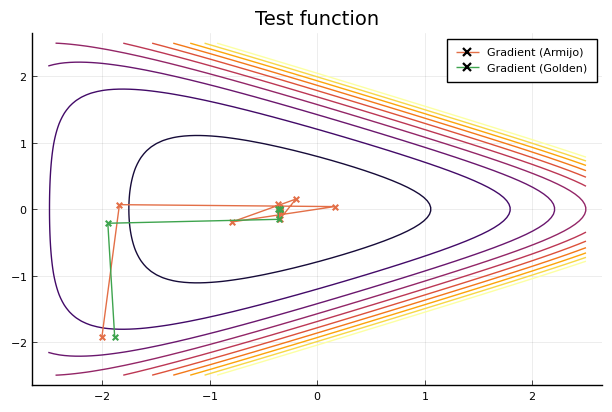

In [18]:
# Gather the history of the iterations for the Gradient method with Armijo rule as an inexact line search
## TODO: Don't forget to set the last parameter to 'true' implying that you want to receive the history of the iterations as an output
(xga, kga) = Gradient(f, x, N, ARMIJO, true)

# Gather the history of the iterations for the Gradient method with Golden section rule as an exact line search
## TODO: Don't forget to set the last parameter to 'true' implying that you want to receive the history of the iterations as an output
(xgg, kgg) = Gradient(f, x, N, GOLDEN, true)

# Defining the interval for the x1(x) and x2(y) axes
x = range( -2.5, 2.5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f([x,y]), 
    title  = "Test function",
    levels = [0.0 + 5i for i = 1:10],
    cbar = false,
    clims = (0,50)
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(xga[:,1], xga[:,2], label = "Gradient (Armijo)", marker=:x)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(xgg[:,1], xgg[:,2], label = "Gradient (Golden)", marker=:x)

# Saving the figure as .pdf file if needed
savefig("test_function_Gradient.pdf")

## Function calls for tasks (1) - (3)

Below we define the parameters' values used for the experiments.
Notice that some parameters must be set by you.

In [55]:
# Parameters to be set by you.
## TODO: set the values for α₀, β₀, and heavy_ball_weight. 
α₀  = 0.01              # slope reduction factor for Armijo's method
β₀  = 0.7               # λ reduction factor for Armijo's method
heavy_ball_weight = 0.1 # Heavy ball weighting parameter

# Predefined parameters (nothing to be changed from here onwards)
N   = 10000             # Number of iterations 
a₀  = 0.0               # initial lower bound for Golden section method
b₀  = 10.0              # initial upper bound for Golden section method
λ₀  = 2.0               # initial step size value (e.g. 2) for Armijo's method
tol = 1e-5              # Solution tolerance

1.0e-5

In [56]:
# Task (1)
## TODO: Uncomment the line you need

# Function for task (1)
f1(x) = 2*(0.5x[1]^2 + 4x[2]^2) - 0.5*x[1]*x[2] 

# Starting point for f1
x1 = [-10.0, 10.0]      

# (1): just cost and iterations. 
@show (f1gg, k1gg) = Gradient(f1, x1, N, GOLDEN, false)
@time (f1gg, k1gg) = Gradient(f1, x1, N, GOLDEN, false)

@show (f1ga, k1ga) = Gradient(f1, x1, N, ARMIJO, false)
@time (f1ga, k1ga) = Gradient(f1, x1, N, ARMIJO, false)

@show (f1hg, k1hg) = Heavy_ball(f1, x1, N, GOLDEN, heavy_ball_weight, false)
@time (f1hg, k1hg) = Heavy_ball(f1, x1, N, GOLDEN, heavy_ball_weight, false)

@show (f1ha, k1ha) = Heavy_ball(f1, x1, N, ARMIJO, heavy_ball_weight, false)
@time (f1ha, k1ha) = Heavy_ball(f1, x1, N, ARMIJO, heavy_ball_weight, false)


# (1): history and iterations
(x1gg, k1gg) = Gradient(f1, x1, N, GOLDEN, true)
(x1ga, k1ga) = Gradient(f1, x1, N, ARMIJO, true)
(x1hg, k1hg) = Heavy_ball(f1, x1, N, GOLDEN, heavy_ball_weight, true)
(x1ha, k1ha) = Heavy_ball(f1, x1, N, ARMIJO, heavy_ball_weight, true)

(f1gg, k1gg) = Gradient(f1, x1, N, GOLDEN, false) = (1.2037704085018674e-11, 35)
  0.000544 seconds (4.88 k allocations: 322.750 KiB)
(f1ga, k1ga) = Gradient(f1, x1, N, ARMIJO, false) = (6.014598451709991e-12, 64)
  0.000514 seconds (2.18 k allocations: 113.641 KiB)
(f1hg, k1hg) = Heavy_ball(f1, x1, N, GOLDEN, heavy_ball_weight, false) = (1.0616619514223661e-11, 513)
  0.008157 seconds (92.88 k allocations: 5.058 MiB)
(f1ha, k1ha) = Heavy_ball(f1, x1, N, ARMIJO, heavy_ball_weight, false) = (2.815271063607792e-12, 516)
  0.001984 seconds (17.03 k allocations: 994.984 KiB)


([-9.998384201077199 9.989335727109514; -9.996604064675129 9.977594269302214; … ; 1.1889242289969298e-6 -9.550852080628313e-7; 8.969627340991119e-7 5.301523816448805e-7], 516)

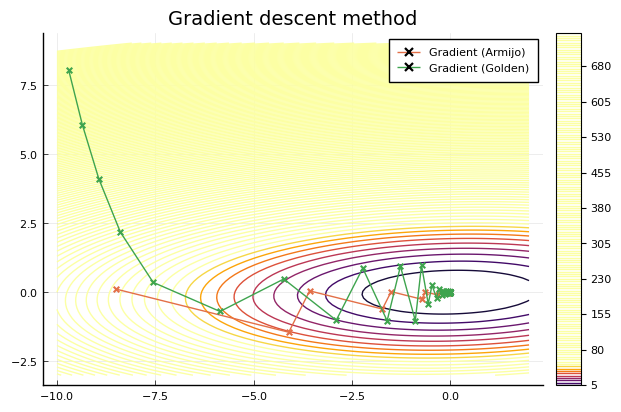

In [41]:
# Defining the interval for the x1(x) and x2(y) axes
#using Gadfly
x = range( -10, 2, length = 100)
y = range( -3, 9, length = 100)#copy(x)
# Plotting the contour of the function 
contour(x,y, (x,y) -> f1([x,y]), 
    title  = "Gradient descent method",
    levels = [0.0 + 5i for i = 1:150],
    cbar = true,
    clims = (0,50)
)
plot!(x1gg[:,1], x1gg[:,2], label = "Gradient (Armijo)", marker=:x)
# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
#plot!(x1gg[:,1], k1gg[:,2], label = "Gradient (Armijo)", marker=:x)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(x1ga[:,1], x1ga[:,2], label = "Gradient (Golden)", marker=:x)

# Saving the figure as .pdf file if needed
savefig("function1_Gradient.pdf")

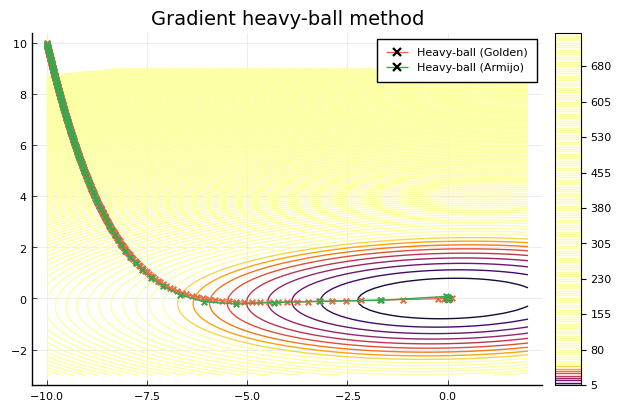

In [58]:
x = range( -10, 2, length = 100)
y = range( -3, 9, length = 100)#copy(x)
# Plotting the contour of the function 
contour(x,y, (x,y) -> f1([x,y]), 
    title  = "Gradient heavy-ball method",
    levels = [0.0 + 5i for i = 1:150],
    cbar = true,
    clims = (0,50)
)
plot!(x1ha[:,1], x1ha[:,2], label = "Heavy-ball (Golden)", marker=:x)
plot!(x1hg[:,1], x1hg[:,2], label = "Heavy-ball (Armijo)", marker=:x)
# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
#plot!(x1gg[:,1], k1gg[:,2], label = "Gradient (Armijo)", marker=:x)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
#plot!(x1ha[:,1], x1ha[:,2], label = "Heavy-ball (Golden)", marker=:x)

# Saving the figure as .pdf file if needed
savefig("function1_Gradient.pdf")

In [ ]:
# Task (2)
## TODO: Uncomment the line you need

# Function for task (2)
f2(x) = exp(x[1] + 2*x[2] - 0.1) + exp(x[1] - 2*x[2] - 0.1) + exp(-x[1] - 0.2) 

# Starting point for f2
x2 = [-2.5, -3.5]      

# (2): (just cost and iterations)
#@show (f2gg, k2gg) = Gradient(f2, x2, N, GOLDEN, false)
#@time (f2gg, k2gg) = Gradient(f2, x2, N, GOLDEN, false)

#@show (f2ga, k2ga) = Gradient(f2, x2, N, ARMIJO, false)
#@time (f2ga, k2ga) = Gradient(f2, x2, N, ARMIJO, false)

#@show (f2hg, k2hg) = Heavy_ball(f2, x2, N, GOLDEN, heavy_ball_weight, false)
#@time (f2hg, k2hg) = Heavy_ball(f2, x2, N, GOLDEN, heavy_ball_weight, false)

#@show (f2ha, k2ha) = Heavy_ball(f2, x2, N, ARMIJO, heavy_ball_weight, false)
#@time (f2ha, k2ha) = Heavy_ball(f2, x2, N, ARMIJO, heavy_ball_weight, false)

#@show (f2ng, k2ng) = Newton(f2, x2, N, GOLDEN, false)
#@time (f2ng, k2ng) = Newton(f2, x2, N, GOLDEN, false)

#@show (f2na, k2na) = Newton(f2, x2, N, ARMIJO, false)
#@time (f2na, k2na) = Newton(f2, x2, N, ARMIJO, false)

#@show (f2bg, k2bg) = BFGS(f2, x2, N, GOLDEN, false)
#@time (f2bg, k2bg) = BFGS(f2, x2, N, GOLDEN, false)

#@show (f2ba, k2ba) = BFGS(f2, x2, N, ARMIJO, false)
#@time (f2ba, k2ba) = BFGS(f2, x2, N, ARMIJO, false)

# (2): (history and iterations)
#(x2gg, k2gg) = Gradient(f2, x2, N, GOLDEN, true)
#(x2ga, k2ga) = Gradient(f2, x2, N, ARMIJO, true)
#(x2hg, k2hg) = Heavy_ball(f2, x2, N, GOLDEN, heavy_ball_weight, true)
#(x2ha, k2ha) = Heavy_ball(f2, x2, N, ARMIJO, heavy_ball_weight, true)
#(x2ng, k2ng) = Newton(f2, x2, N, GOLDEN, true)
#(x2na, k2na) = Newton(f2, x2, N, ARMIJO, true)
#(x2bg, k2bg) = BFGS(f2, x2, N, GOLDEN, true)
#(x2ba, k2ba) = BFGS(f2, x2, N, ARMIJO, true)

In [ ]:
# Task (3)
## TODO: Uncomment the line you need

# Function for task (3)
f3(x) = (x[1]^2 + x[2] - 10)^2 + (x[1] + x[2]^2 - 15)^2

# Starting point for f3
x3 = [-0.5, -2.0]     

# (3): (just cost and iterations)
#@show (f3gg, k3gg) = Gradient(f3, x3, N, GOLDEN, false)
#@time (f3gg, k3gg) = Gradient(f3, x3, N, GOLDEN, false)

#@show (f3ga, k3ga) = Gradient(f3, x3, N, ARMIJO, false)
#@time (f3ga, k3ga) = Gradient(f3, x3, N, ARMIJO, false)

#@show (f3hg, k3hg) = Heavy_ball(f3, x3, N, GOLDEN, heavy_ball_weight, false)
#@time (f3hg, k3hg) = Heavy_ball(f3, x3, N, GOLDEN, heavy_ball_weight, true)

#@show (f3ha, k3ha) = Heavy_ball(f3, x3, N, ARMIJO, heavy_ball_weight, false)
#@time (f3ha, k3ha) = Heavy_ball(f3, x3, N, ARMIJO, heavy_ball_weight, false)

#@show (f3ng, k3ng) = Newton(f3, x3, N, GOLDEN, false)
#@time (f3ng, k3ng) = Newton(f3, x3, N, GOLDEN, true)

#@show (f3na, k3na) = Newton(f3, x3, N, ARMIJO, false)
#@time (f3na, k3na) = Newton(f3, x3, N, ARMIJO, false)

#@show (f3bg, k3bg) = BFGS(f3, x3, N, GOLDEN, false)
#@time (f3bg, k3bg) = BFGS(f3, x3, N, GOLDEN, true)

#@show (f3ba, k3ba) = BFGS(f3, x3, N, ARMIJO, false)
#@time (f3ba, k3ba) = BFGS(f3, x3, N, ARMIJO, false)

# (3) (history and iterations)
#(x3gg, k3gg) = Gradient(f3, x3, N, GOLDEN, true)
#(x3ga, k3ga) = Gradient(f3, x3, N, ARMIJO, true)
#(x3hg, k3hg) = Heavy_ball(f3, x3, N, GOLDEN, heavy_ball_weight, true)
#(x3ha, k3ha) = Heavy_ball(f3, x3, N, ARMIJO, heavy_ball_weight, true)
#(x3ng, k3ng) = Newton(f3, x3, N, GOLDEN, true)
#(x3na, k3na) = Newton(f3, x3, N, ARMIJO, true)
#(x3bg, k3bg) = BFGS(f3, x3, N, GOLDEN, true)
#(x3ba, k3ba) = BFGS(f3, x3, N, ARMIJO, true)


## Performance profiles

In [ ]:
using Random # for generating the instances

## Generate a random symmetric positive definite matrix
## A ∈ ℜⁿˣⁿ and a random vector b ∈ ℜⁿ
function generate_problem_data(n::Int, δ::Float64)
    A = randn(n,n)                # Create random matrix
    A = (A + A')/2                # Make A symmetric
    if isposdef(A) == false       # Check if A is PD
        λᵢ = eigmin(A)            # Minimum eigenvalue
        A = A + (abs(λᵢ) + δ)*I   # Add λᵢ + δ to diagonal elements
    end
    @assert(isposdef(A))          # Final PD test
    b = randn(n)                  # Create random vector b
    return (A,b)                  # Resulting matrix A is PD
end


## Generate k test instances of dimension n
function generate_instances(k::Int, n::Int, δ::StepRangeLen)
    A = Dict{Int,Matrix{Float64}}()   # Store matrices A
    b = Dict{Int,Vector{Float64}}()   # Store vectors  b
    for i = 1:k
        ## NOTE: Change δ between, e.g., δ ∈ [0.01, 1] to get different
        ##       condition numbers for matrix A
        (A[i], b[i]) = generate_problem_data(n, δ[i])
    end
    return (A, b)
end

Random.seed!(0)                             # Control randomness
k = 100                                     # Number of intances to generate
n = 150                                     # Dimension of PD matrix A ∈ ℜⁿˣⁿ
δ1 = range(0.05, length = k, step = 0.05)   # Moderate condition numbers for matrices A
δ2 = range(0.01, length = k, step = 0.01)   # Larger condition numbers for matrices A


## Generate problem data with δ1 and δ2
(A1, b1) = generate_instances(k, n, δ1)
(A2, b2) = generate_instances(k, n, δ2)


## Function to minimize with two different data
f1(x,i) = (1/2)*dot(x, A1[i]*x) - dot(b1[i], x)
f2(x,i) = (1/2)*dot(x, A2[i]*x) - dot(b2[i], x)

## Optimal solution costs
fopt = zeros(k,2)
for i = 1:k
    x1 = A1[i]\b1[i]
    x2 = A2[i]\b2[i]
    fopt[i,1] = f1(x1,i)
    fopt[i,2] = f2(x2,i)
end

###### Preallocate data #######

# Solution costs
fval_gradient_golden   = zeros(k, 2)
fval_gradient_armijo   = zeros(k, 2)
fval_heavy_ball_golden = zeros(k, 2)
fval_heavy_ball_armijo = zeros(k, 2)
fval_newton_golden     = zeros(k, 2)
fval_newton_armijo     = zeros(k, 2)
fval_bfgs_golden       = zeros(k, 2)
fval_bfgs_armijo       = zeros(k, 2)

# Solution times
time_gradient_golden   = zeros(k, 2)
time_gradient_armijo   = zeros(k, 2)
time_heavy_ball_golden = zeros(k, 2)
time_heavy_ball_armijo = zeros(k, 2)
time_newton_golden     = zeros(k, 2)
time_newton_armijo     = zeros(k, 2)
time_bfgs_golden       = zeros(k, 2)
time_bfgs_armijo       = zeros(k, 2)

# Number of iterations
iter_gradient_golden   = zeros(Int, k, 2)
iter_gradient_armijo   = zeros(Int, k, 2)
iter_heavy_ball_golden = zeros(Int, k, 2)
iter_heavy_ball_armijo = zeros(Int, k, 2)
iter_newton_golden     = zeros(Int, k, 2)
iter_newton_armijo     = zeros(Int, k, 2)
iter_bfgs_golden       = zeros(Int, k, 2)
iter_bfgs_armijo       = zeros(Int, k, 2)

# Solution status
stat_gradient_golden   = fill(false, k, 2)
stat_gradient_armijo   = fill(false, k, 2)
stat_heavy_ball_golden = fill(false, k, 2)
stat_heavy_ball_armijo = fill(false, k, 2)
stat_newton_golden     = fill(false, k, 2)
stat_newton_armijo     = fill(false, k, 2)
stat_bfgs_golden       = fill(false, k, 2)
stat_bfgs_armijo       = fill(false, k, 2)

ns  = 8                          # Number of solvers (methods) to compare
np  = k                          # Number of problems to solve
computing_time = zeros(np,ns,2)  # Computing times for each problem/method.

# Resetting the parameters for the performance profiles
# !Do not change these parameters hereafrer
                                 
N   = 10000                      # Number of iterations
x₀  = ones(n)                    # Starting point
tol = 1e-5                       # Solution tolerance
a₀  = 0.0                        # initial lower bound for Golden section method
b₀  = 10.0                       # initial upper bound for Golden section method
λ₀  = 1.5                        # initial step size value for Armijo's method

α₀  = 0.01                       # slope reduction factor for Armijo's method
β₀  = 0.7                        # λ reduction factor for Armijo's method
heavy_ball_weight = 0.5          # Heavy ball weighting parameter

In [ ]:
tini = time()
## Go through all instances for both sets of data
for j = 1:2 
    for i = 1:k
  
        @info "Solving problem $(j), run $(i)/$(k)."        
        ## Function to minimize
        g1(x) = f1(x,i)
        g2(x) = f2(x,i)
    
        ## Gradient + Golden
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = Gradient(g1, x₀, N, GOLDEN, false)
        else
            (fvalue, numiter) = Gradient(g2, x₀, N, GOLDEN, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_golden[i, j] = fvalue       # Objective value
        time_gradient_golden[i, j] = soltime      # Solution time
        iter_gradient_golden[i, j] = numiter      # Iteration count
        stat_gradient_golden[i, j] = status       # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 1, j] = soltime : computing_time[i, 1, j] = Inf    
    
        ## Gradient + Armijo
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = Gradient(g1, x₀, N, ARMIJO, false)
        else
            (fvalue, numiter) = Gradient(g2, x₀, N, ARMIJO, false)
        end
        soltime = time() - starttime            # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_armijo[i, j] = fvalue     # Objective value
        time_gradient_armijo[i, j] = soltime    # Solution time
        iter_gradient_armijo[i, j] = numiter    # Iteration count
        stat_gradient_armijo[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 2, j] = soltime : computing_time[i, 2, j] = Inf  
    
        ## Heavy ball + Golden
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = Heavy_ball(g1, x₀, N, GOLDEN, heavy_ball_weight, false)
        else
            (fvalue, numiter) = Heavy_ball(g2, x₀, N, GOLDEN, heavy_ball_weight, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_golden[i, j] = fvalue     # Objective value
        time_heavy_ball_golden[i, j] = soltime    # Solution time
        iter_heavy_ball_golden[i, j] = numiter    # Iteration count
        stat_heavy_ball_golden[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 3, j] = soltime : computing_time[i, 3, j] = Inf  
    
        ## Heavy ball + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = Heavy_ball(g1, x₀, N, ARMIJO, heavy_ball_weight, false)
        else
            (fvalue, numiter) = Heavy_ball(g2, x₀, N, ARMIJO, heavy_ball_weight, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_armijo[i, j] = fvalue     # Objective value
        time_heavy_ball_armijo[i, j] = soltime    # Solution time
        iter_heavy_ball_armijo[i, j] = numiter    # Iteration count
        stat_heavy_ball_armijo[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 4, j] = soltime : computing_time[i, 4, j] = Inf  

        ## Newton + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = Newton(g1, x₀, N, GOLDEN, false)
        else
            (fvalue, numiter) = Newton(g2, x₀, N, GOLDEN, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_golden[i, j] = fvalue         # Objective value
        time_newton_golden[i, j] = soltime        # Solution time
        iter_newton_golden[i, j] = numiter        # Iteration count
        stat_newton_golden[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 5, j] = soltime : computing_time[i, 5, j] = Inf
    
        ## Newton + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = Newton(g1, x₀, N, ARMIJO, false)
        else
            (fvalue, numiter) = Newton(g2, x₀, N, ARMIJO, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_armijo[i, j] = fvalue         # Objective value
        time_newton_armijo[i, j] = soltime        # Solution time
        iter_newton_armijo[i, j] = numiter        # Iteration count
        stat_newton_armijo[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 6, j] = soltime : computing_time[i, 6, j] = Inf    
        
        ## BFGS + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = BFGS(g1, x₀, N, GOLDEN, false)
        else
            (fvalue, numiter) = BFGS(g2, x₀, N, GOLDEN, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_golden[i, j] = fvalue           # Objective value
        time_bfgs_golden[i, j] = soltime          # Solution time
        iter_bfgs_golden[i, j] = numiter          # Iteration count
        stat_bfgs_golden[i, j] = status           # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 7, j] = soltime : computing_time[i, 7, j] = Inf
    
        ## BFGS + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = BFGS(g1, x₀, N, ARMIJO, false)
        else
            (fvalue, numiter) = BFGS(g2, x₀, N, ARMIJO, false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_armijo[i, j] = fvalue           # Objective value
        time_bfgs_armijo[i, j] = soltime          # Solution time
        iter_bfgs_armijo[i, j] = numiter          # Iteration count
        stat_bfgs_armijo[i, j] = status           # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 8, j] = soltime : computing_time[i, 8, j] = Inf
    end    
end
tend = time() - tini

## Plot performance profiles

In [ ]:
for j = 1:2
    ###### Plot performance profiles ######
    computing_time_min = minimum(computing_time[:, :, j], dims = 2)    # Minimum time for each instance
    performance_ratios = computing_time[:, :, j] ./ computing_time_min # Compute performance ratios

    τ = sort(unique(performance_ratios))  # Sort the performance ratios in increasing order
    τ[end] == Inf && pop!(τ)  # Remove the Inf element if it exists

    ns = 8                    # Number of solvers
    np = k                    # Number of problems

    ρS = Dict()               # Compute cumulative distribution functions
    for i = 1:ns              # for performance ratios
        ρS[i] = [sum(performance_ratios[:,i] .<= τi) / np for τi in τ]
    end

    # Plot performance profiles
    labels = ["Gradient (Exact)", "Gradient (Armijo)", "Heavy ball (Exact)", "Heavy ball (Armijo)",
              "Newton (Exact)", "Newton (Armijo)", "BFGS (Exact)", "BFGS (Armijo)"]

    styles = [:solid, :dash, :dot, :dashdot, :solid, :dash, :solid, :dash,]
    plot(xscale = :log2,  
         yscale = :none,
         xlim   = (1, maximum(τ)),
         ylim   = (0, 1),
         xlabel = "τ",
         ylabel = "P(performance_ratios ≤ τ : 1 ≤ s ≤ np)",
         title  = "Perfomance plot (condition $(j))",
         yticks = 0.0:0.1:1.0,
         size   = (1200,800),
         reuse  = false,
         tickfontsize   = 8,
         legendfontsize = 10,
         guidefontsize  = 10,
         grid = true)
    for i = 1:ns
      plot!(τ, ρS[i], label = labels[i], seriestype = :steppre, linewidth = 2, line = styles[i])
    end
    savefig("performance_plot_$(j).pdf")
end